In [1]:
import tensorflow as tf
import tf_mapper
from importlib import reload
import pandas as pd
import numpy as np
reload(tf_mapper)
from sklearn.model_selection import train_test_split
from tf_mapper import get_batched_dataset
# tf.enable_eager_execution()
# Helperfunctions to make your feature definition more readable
import numpy as np
import pickle as pkl
allResults = pkl.load(open("/n/scratch2/ms994/realPd.pkl", "rb"))

/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ms994/miniconda3/envs/keras-

In [ ]:
np.fft

In [ ]:
allResults[0]

In [ ]:
fft_data = np.nan_to_num(
                np.abs(
                    np.fft.fft(
                        allResults[0][0],
                        axis=0)))

In [16]:
allShapes = [allResults[i][0].shape[0] for i in range(len(allResults))]

In [3]:
allResults = list(filter(lambda x: x[0].shape[0] >= 1500, allResults))
allResults = list(filter(lambda x: x[1].shape[0] >= 1500, allResults))
allResults = list(filter(lambda x: x[2].shape[0] >= 1500, allResults))

In [5]:
len(allResults)

41079

In [6]:
allLabels = [datum[3] for datum in allResults]

In [10]:
allLabels = pd.concat(allLabels, axis=1).T

In [29]:
subset = allLabels.dropna(subset=["on_off"])

In [31]:
subset.on_off = subset.on_off.astype(np.int)

/home/ms994/miniconda3/envs/keras-redo-cpu/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [32]:
subset.groupby("subject_id")["on_off"].mean()

subject_id
hbv013    0.289764
hbv014    0.355903
hbv022    0.175163
hbv038    0.456245
hbv043    0.543519
hbv051    0.250000
hbv077    0.185320
Name: on_off, dtype: float64

In [37]:
analyzed = subset.join(subset.groupby("subject_id")["on_off"].mean(), on="subject_id", lsuffix="mean")

In [40]:
((analyzed.on_off - analyzed.on_offmean)**2).mean()

0.19812964333512767

In [4]:
allResults = (list(filter(lambda x: (x[0].std(0) > 0.01).any() and (x[1].std(0) > 0.01).any() and (x[2].std(0) > 0.01).any(), allResults)))

/home/ms994/miniconda3/envs/keras-redo-cpu/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [73]:
allResults[0][0][:1500]

array([[ 8.7292595, -4.4412445, -3.016694 ],
       [ 8.7148945, -4.465186 , -2.8514945],
       [ 8.659828 , -4.46758  , -2.8419175],
       ...,
       [-2.466028 , -9.0021985, -4.5944725],
       [-2.200271 , -8.942343 , -4.6303855],
       [-2.1188685, -8.748413 , -4.831499 ]])

In [89]:
allResults[0][3]

measurement_id     b36b10ee-94d2-47e1-bc24-59760c976e6b
subject_id                                       hbv022
on_off                                                0
dyskinesia                                          NaN
tremor                                                0
device_id                                          327T
smartwatch_data                                    True
gyro_data                                          True
smartphone_data                                    True
Name: 2, dtype: object

In [94]:
def get_real_pd_i(ind):
    watch_accel_fft = np.nan_to_num(np.abs(np.fft.fft(allResults[ind][0][:1500], axis=0)))[0:750]
    watch_gyro_fft = np.nan_to_num(np.abs(np.fft.fft(allResults[ind][1][:1500], axis=0)))[0:750]
    phone_accel_fft = np.nan_to_num(np.abs(np.fft.fft(allResults[ind][2][:1500], axis=0)))[0:750]
    return (watch_accel_fft, watch_gyro_fft, phone_accel_fft, allResults[ind][3])


def write_data(toRunQ, toReturnQ):
    for ind in iter(toRunQ.get, None):
        data_samples = get_real_pd_i(ind) 
        toReturnQ.put(data_samples)

In [96]:
from multiprocessing import Process, Manager
m = Manager()
n_process = 12
toRunQ = m.Queue()
toReturnQ = m.Queue()
p = [Process(target=write_data, args=(toRunQ, toReturnQ)) for i in range(n_process)]
[toRunQ.put(i) for i in range(len(allResults))]
[toRunQ.put(None) for i in range(n_process)]


[None, None, None, None, None, None, None, None, None, None, None, None]

In [97]:
[proc.start() for proc in p]

[None, None, None, None, None, None, None, None, None, None, None, None]

In [98]:
[proc.join() for proc in p]

[None, None, None, None, None, None, None, None, None, None, None, None]

In [99]:
allResults = []
while not toReturnQ.empty():
    allResults.append(toReturnQ.get())

In [103]:
allResults[1000][0].shape

(750, 3)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.log(fft_data[:,0]))

In [4]:
allResults = pkl.load(open("/n/scratch2/ms994/realFFTPd.pkl","rb"))

In [60]:
num_cnn_layers = 4
num_lstm_layers = 0
dropout = 0.5
lin_h=128
watch_accel = tf.keras.layers.Input((750, 3), name="watch_accel_in")
watch_gyro = tf.keras.layers.Input((750, 3), name="watch_gyro_in")
phone_accel = tf.keras.layers.Input((750, 3), name="phone_accel_in")
all_inputs = [watch_accel, watch_gyro, phone_accel]
all_encoder_out = []

for inputLayer in all_inputs:
    x = inputLayer
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1000)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(750)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(500)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)

   

    x = tf.keras.layers.Flatten()(x)
    all_encoder_out.append(x)

x = tf.keras.layers.Concatenate()(all_encoder_out)
x = tf.keras.layers.Dense(1000)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1000)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.BatchNormalization()(x)
x_shared = x
all_output_names = ["watch_accel_out", "watch_gyro_out", "phone_accel_out"]
all_outputs = []
for outputLayer in all_output_names:
    x = tf.keras.layers.Flatten()(x_shared)
    x = tf.keras.layers.Dense(500)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(750)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(1000)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(750*3)(x)
    x = tf.keras.layers.Reshape((750,3), name=outputLayer)(x)
    all_outputs.append(x)
model = tf.keras.Model(inputs=all_inputs, outputs=all_outputs)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
watch_accel_in (InputLayer)     (None, 750, 3)       0                                            
__________________________________________________________________________________________________
watch_gyro_in (InputLayer)      (None, 750, 3)       0                                            
__________________________________________________________________________________________________
phone_accel_in (InputLayer)     (None, 750, 3)       0                                            
__________________________________________________________________________________________________
flatten_45 (Flatten)            (None, 2250)         0           watch_accel_in[0][0]             
__________________________________________________________________________________________________
flatten_47

In [27]:
watchAccel =  np.nan_to_num(np.log([datum[0] for datum in allResults]))
watchGyro =  np.nan_to_num(np.log([datum[1] for datum in allResults]))
phoneAccel =  np.nan_to_num(np.log([datum[2] for datum in allResults]))

/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [47]:
watchAccel = np.nan_to_num(watchAccel.astype(np.float32))
watchGyro = np.nan_to_num(watchGyro.astype(np.float32))
phoneAccel = np.nan_to_num(phoneAccel.astype(np.float32))

In [59]:
phoneAccel[phoneAccel < -10] = -10

In [61]:
model.compile(tf.keras.optimizers.Adam(lr=0.005), "logcosh", metrics=["mean_squared_error"])
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint("/n/scratch2/ms994/real_pd_log_fft_autoencoder.h5", monitor="loss", save_best_only=True, verbose=True)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=15)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", patience=1, factor=0.5)
history = model.fit(([watchAccel, watchGyro, phoneAccel]), ([watchAccel, watchGyro, phoneAccel]), epochs=1000, callbacks=[modelCheckpoint, reduceLR, earlyStopping])

Epoch 1/1000
41024/41079 [============================>.] - ETA: 0s - loss: 0.9315 - watch_accel_out_loss: 0.2888 - watch_gyro_out_loss: 0.2836 - phone_accel_out_loss: 0.3590 - watch_accel_out_mean_squared_error: 0.7995 - watch_gyro_out_mean_squared_error: 0.7629 - phone_accel_out_mean_squared_error: 1.1505
Epoch 00001: loss improved from inf to 0.93135, saving model to /n/scratch2/ms994/real_pd_log_fft_autoencoder.h5
41079/41079 [==============================] - 116s 3ms/sample - loss: 0.9313 - watch_accel_out_loss: 0.2887 - watch_gyro_out_loss: 0.2836 - phone_accel_out_loss: 0.3591 - watch_accel_out_mean_squared_error: 0.7992 - watch_gyro_out_mean_squared_error: 0.7626 - phone_accel_out_mean_squared_error: 1.1507
Epoch 2/1000
41024/41079 [============================>.] - ETA: 0s - loss: 0.7661 - watch_accel_out_loss: 0.2354 - watch_gyro_out_loss: 0.2359 - phone_accel_out_loss: 0.2948 - watch_accel_out_mean_squared_error: 0.6024 - watch_gyro_out_mean_squared_error: 0.6005 - phone_ac

41079/41079 [==============================] - 50s 1ms/sample - loss: 0.6040 - watch_accel_out_loss: 0.1863 - watch_gyro_out_loss: 0.1953 - phone_accel_out_loss: 0.2223 - watch_accel_out_mean_squared_error: 0.4614 - watch_gyro_out_mean_squared_error: 0.4856 - phone_accel_out_mean_squared_error: 0.5598
Epoch 24/1000
41056/41079 [============================>.] - ETA: 0s - loss: 0.6074 - watch_accel_out_loss: 0.1870 - watch_gyro_out_loss: 0.1964 - phone_accel_out_loss: 0.2239 - watch_accel_out_mean_squared_error: 0.4631 - watch_gyro_out_mean_squared_error: 0.4883 - phone_accel_out_mean_squared_error: 0.5639
Epoch 00024: loss did not improve from 0.60400
41079/41079 [==============================] - 49s 1ms/sample - loss: 0.6074 - watch_accel_out_loss: 0.1870 - watch_gyro_out_loss: 0.1964 - phone_accel_out_loss: 0.2239 - watch_accel_out_mean_squared_error: 0.4631 - watch_gyro_out_mean_squared_error: 0.4884 - phone_accel_out_mean_squared_error: 0.5639
Epoch 25/1000
41024/41079 [==========

41056/41079 [============================>.] - ETA: 0s - loss: 0.5962 - watch_accel_out_loss: 0.1834 - watch_gyro_out_loss: 0.1916 - phone_accel_out_loss: 0.2211 - watch_accel_out_mean_squared_error: 0.4535 - watch_gyro_out_mean_squared_error: 0.4753 - phone_accel_out_mean_squared_error: 0.5561
Epoch 00047: loss did not improve from 0.59287
41079/41079 [==============================] - 48s 1ms/sample - loss: 0.5964 - watch_accel_out_loss: 0.1835 - watch_gyro_out_loss: 0.1916 - phone_accel_out_loss: 0.2213 - watch_accel_out_mean_squared_error: 0.4536 - watch_gyro_out_mean_squared_error: 0.4754 - phone_accel_out_mean_squared_error: 0.5566
Epoch 48/1000
41056/41079 [============================>.] - ETA: 0s - loss: 0.5979 - watch_accel_out_loss: 0.1843 - watch_gyro_out_loss: 0.1923 - phone_accel_out_loss: 0.2213 - watch_accel_out_mean_squared_error: 0.4557 - watch_gyro_out_mean_squared_error: 0.4771 - phone_accel_out_mean_squared_error: 0.5567
Epoch 00048: loss did not improve from 0.592

In [65]:
model = tf.keras.models.load_model("/n/scratch2/ms994/real_pd_log_fft_autoencoder.h5")

In [66]:
pred=model.predict(([watchAccel, watchGyro, phoneAccel]))

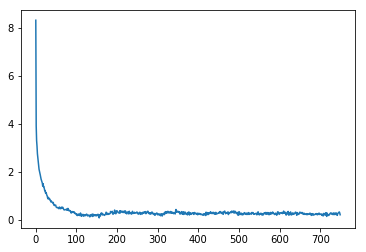

In [84]:
import matplotlib.pyplot as plt
plt.plot(pred[0][14][:,0])
plt.show()

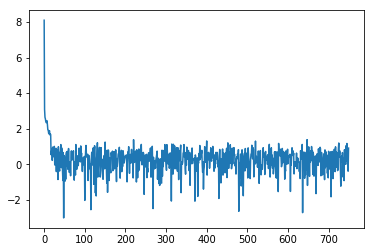

In [85]:
plt.plot(watchAccel[14][:,0])

In [88]:
num_cnn_layers = 4
num_lstm_layers = 0
dropout = 0.5
lin_h=128
watch_accel = tf.keras.layers.Input((750, 3), name="watch_accel_in")
watch_gyro = tf.keras.layers.Input((750, 3), name="watch_gyro_in")
phone_accel = tf.keras.layers.Input((750, 3), name="phone_accel_in")
all_inputs = [watch_accel, watch_gyro, phone_accel]
all_encoder_out = []

for inputLayer in all_inputs:
    x = inputLayer
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1000)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(750)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(500)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)

   

    x = tf.keras.layers.Flatten()(x)
    all_encoder_out.append(x)

x = tf.keras.layers.Concatenate()(all_encoder_out)
x = tf.keras.layers.Dense(1000)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.BatchNormalization()(x)
encoder = tf.keras.Model(inputs=all_inputs, outputs=x)

In [92]:
for i in range(len(encoder.layers)):
    encoder.layers[i].set_weights(model.layers[i].get_weights())

In [94]:
encoded=encoder.predict(([watchAccel, watchGyro, phoneAccel]))

In [103]:
pkl.dump(encoded, open("/n/scratch2/ms994/encoded_real_pd.pkl", "wb"))

In [ ]:
from sklearn.decomposition import FastICA
ica = FastICA()
ica.fit(encoded)

In [21]:
encoded = pkl.load(open("/n/scratch2/ms994/encoded_real_pd.pkl", "rb"))

In [22]:
allLabels = [allResults[i][3] for i in range(len(allResults))]

In [23]:
measurement_id_labels = [allResults[i][3].measurement_id for i in range(len(allResults))]

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
train, test = train_test_split([i for i in range(len(measurement_id_labels))], random_state=1)
train, valid = train_test_split(train, random_state=1)

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
rf = RandomForestClassifier(1000, n_jobs=12)

In [28]:
on_off_labels = [allResults[i][3].on_off for i in range(len(allResults))]

In [29]:
train = pd.Series(on_off_labels)[train].dropna().index.tolist()
valid = pd.Series(on_off_labels)[valid].dropna().index.tolist()
test = pd.Series(on_off_labels)[test].dropna().index.tolist()

In [30]:
encoded.shape, len(allResults)

((41079, 512), 41079)

In [31]:
encoded_train = encoded[train]
on_off_train_labels = pd.Series(on_off_labels)[train]

In [32]:
rf.fit(encoded_train, on_off_train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=12, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [33]:
pred = rf.predict(encoded[valid])

In [34]:
from sklearn.metrics import mean_squared_error
mean_squared_error(pd.Series(on_off_labels)[valid].to_list(), pred)

0.2155297532656023

In [35]:
import seaborn as sns

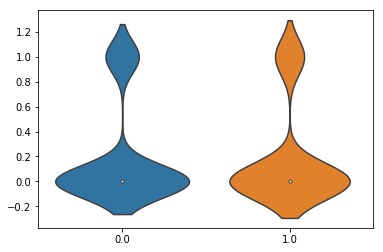

In [37]:
sns.violinplot(x=pd.Series(on_off_labels)[valid], y=pred)